# Harmony - Pu et al 2021

In [1]:
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import pathlib as pt
import matplotlib as mpl
import matplotlib.pyplot as plt

scr_path = '/nfs/team292/hm11/endo_GLND/starsolo/GLND/Thyroid/snippets'
sys.path.append(scr_path)
import singleCellFun as sf

f,_ = sf.makeOutoutFolders()
sf.nbInit(f)

import warnings
warnings.filterwarnings("ignore")

# loading adata

In [2]:
# read saved file
adata = sc.read(pt.Path().absolute().parent / 'workingObj' / 'Pu_2021.h5ad')
sf.summaryTable(adata,['donor_id'])

[INFO] - total cells: 50750


In [3]:
adata.X[:10,:10].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Calculate QC

In [4]:
adata.var_names_make_unique()

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

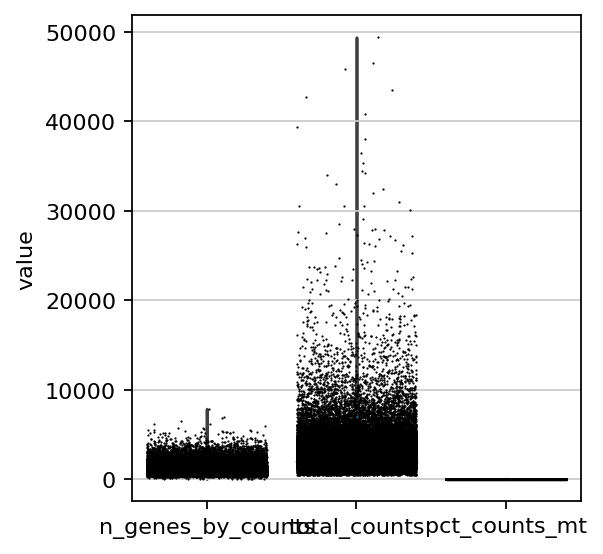

In [7]:
sc.pl.violin(adata,["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4)

In [8]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [9]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

filtered out 1098 cells that have less than 500 genes expressed
filtered out 10014 genes that are detected in less than 3 cells
49652 23680


In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Identify HVGs

In [11]:
print(f'adata shape: {adata.shape}')


# del(bdata)
bdata = adata.copy()

adata shape: (49652, 23680)


In [12]:
sc.pp.highly_variable_genes(bdata,
                            flavor='seurat_v3',
                            layer='counts',
                            n_top_genes=2000,
                            subset=False)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


## PCA

Total number of cells: 49652
Total number of genes: 2000
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)


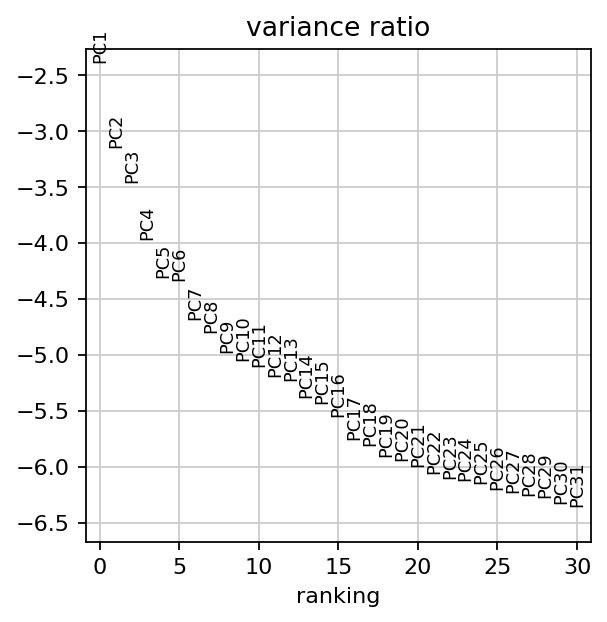

In [13]:
bdata = bdata[:, bdata.var['highly_variable']]
print('Total number of cells: {:d}'.format(bdata.n_obs))
print('Total number of genes: {:d}'.format(bdata.n_vars))

sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)
sc.pl.pca_variance_ratio(bdata, log=True)

# adata.var['highly_variable'] = bdata.var['highly_variable']
# adata.var['highly_variable'].fillna(value=False, inplace=True) # fill NaNs with False so that subsetting to HVGs is possible
# adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
# adata.uns['pca'] = bdata.uns['pca'].copy()
# adata.varm['PCs'] = np.zeros(shape=(adata.n_vars, 50))
# adata.varm['PCs'][adata.var['highly_variable']] = bdata.varm['PCs']

## Harmony

In [14]:
# code from Luz 
# Extract PCA matrix and batch array
n_pcs = 5
pca = bdata.obsm['X_pca'][:, 0:(n_pcs)]

import harmonypy as hm
ho = hm.run_harmony(pca, bdata.obs, 'batch', theta = 0)

# Add harmony values to the anndata object
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
adata.obsm['X_pca'] = res.to_numpy().T

del(bdata)

# Visualize
sc.pp.neighbors(adata, n_pcs = n_pcs)
sc.tl.umap(adata)

2025-05-25 09:01:09,074 - harmonypy - INFO - Iteration 1 of 10
2025-05-25 09:01:43,443 - harmonypy - INFO - Iteration 2 of 10
2025-05-25 09:01:58,540 - harmonypy - INFO - Iteration 3 of 10
2025-05-25 09:02:36,968 - harmonypy - INFO - Iteration 4 of 10
2025-05-25 09:03:11,844 - harmonypy - INFO - Iteration 5 of 10
2025-05-25 09:03:32,659 - harmonypy - INFO - Iteration 6 of 10
2025-05-25 09:03:58,452 - harmonypy - INFO - Iteration 7 of 10
2025-05-25 09:04:06,560 - harmonypy - INFO - Iteration 8 of 10
2025-05-25 09:04:18,242 - harmonypy - INFO - Converged after 8 iterations


computing neighbors
    using 'X_pca' with n_pcs = 5
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:40)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:48)


In [15]:
bk_adata = adata.copy()
# adata = bk_adata.copy()

## UMAP

In [16]:
sc.tl.leiden(adata,resolution=2)

running Leiden clustering
    finished: found 45 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:18)


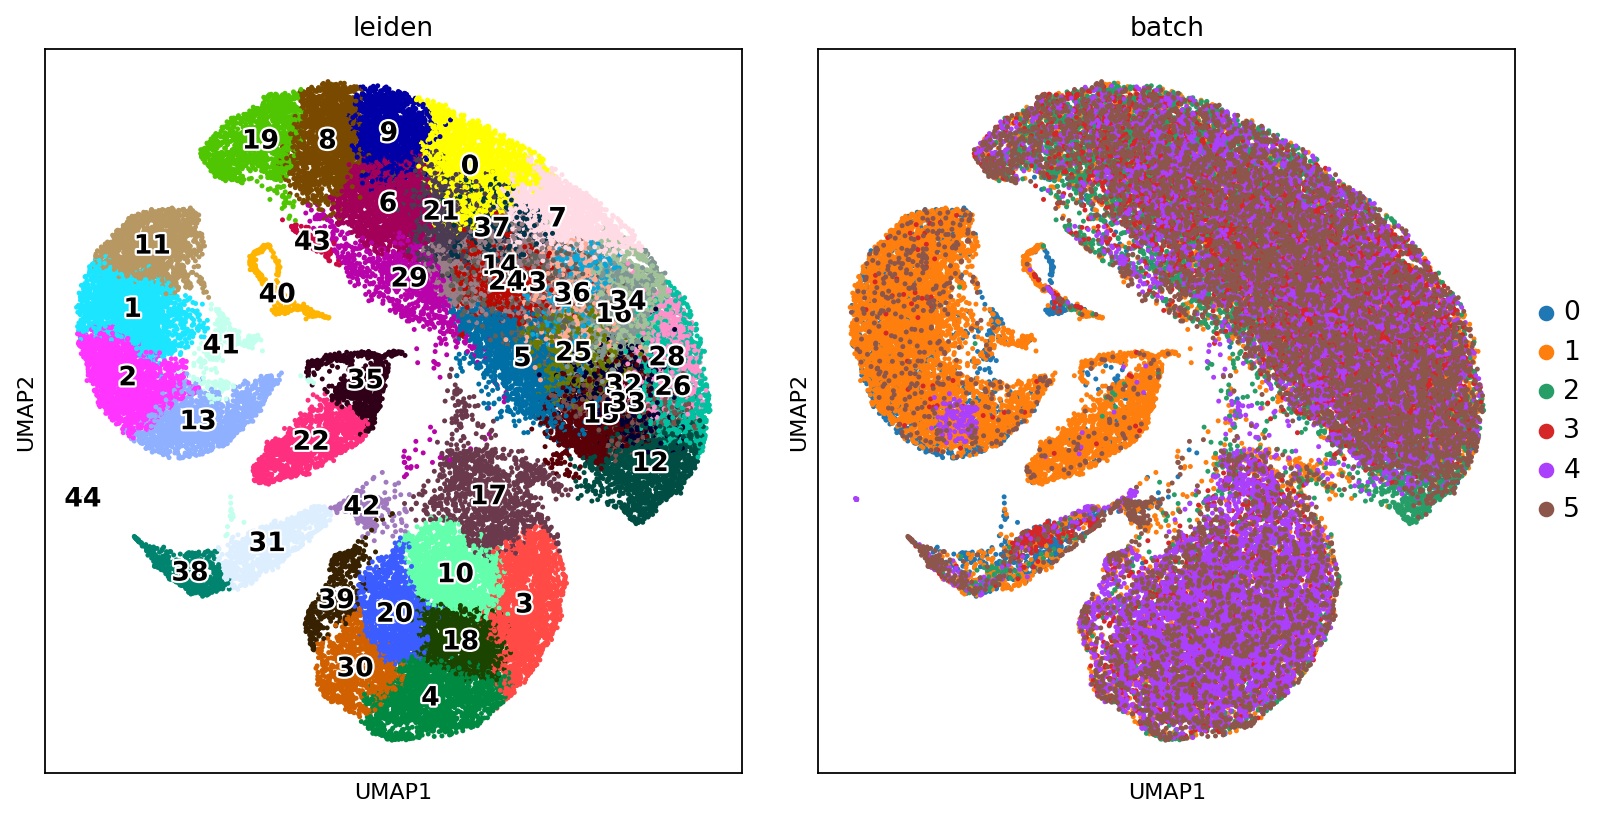

In [17]:
# use scVI imputed values for plotting
s=20
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5),constrained_layout=True, subplot_kw=dict(aspect='equal'))
sc.pl.umap(adata, color=["leiden"], legend_loc='on data',legend_fontsize='large', legend_fontoutline=2, ax=ax1, show=False,s=s)
sc.pl.umap(adata, color=["batch"],legend_fontsize='large',ax=ax2, show=False, s=s)
fig.show()
# plt.savefig('figures/thy_harmony0_theta0.pdf')

running Leiden clustering
    finished: found 58 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)


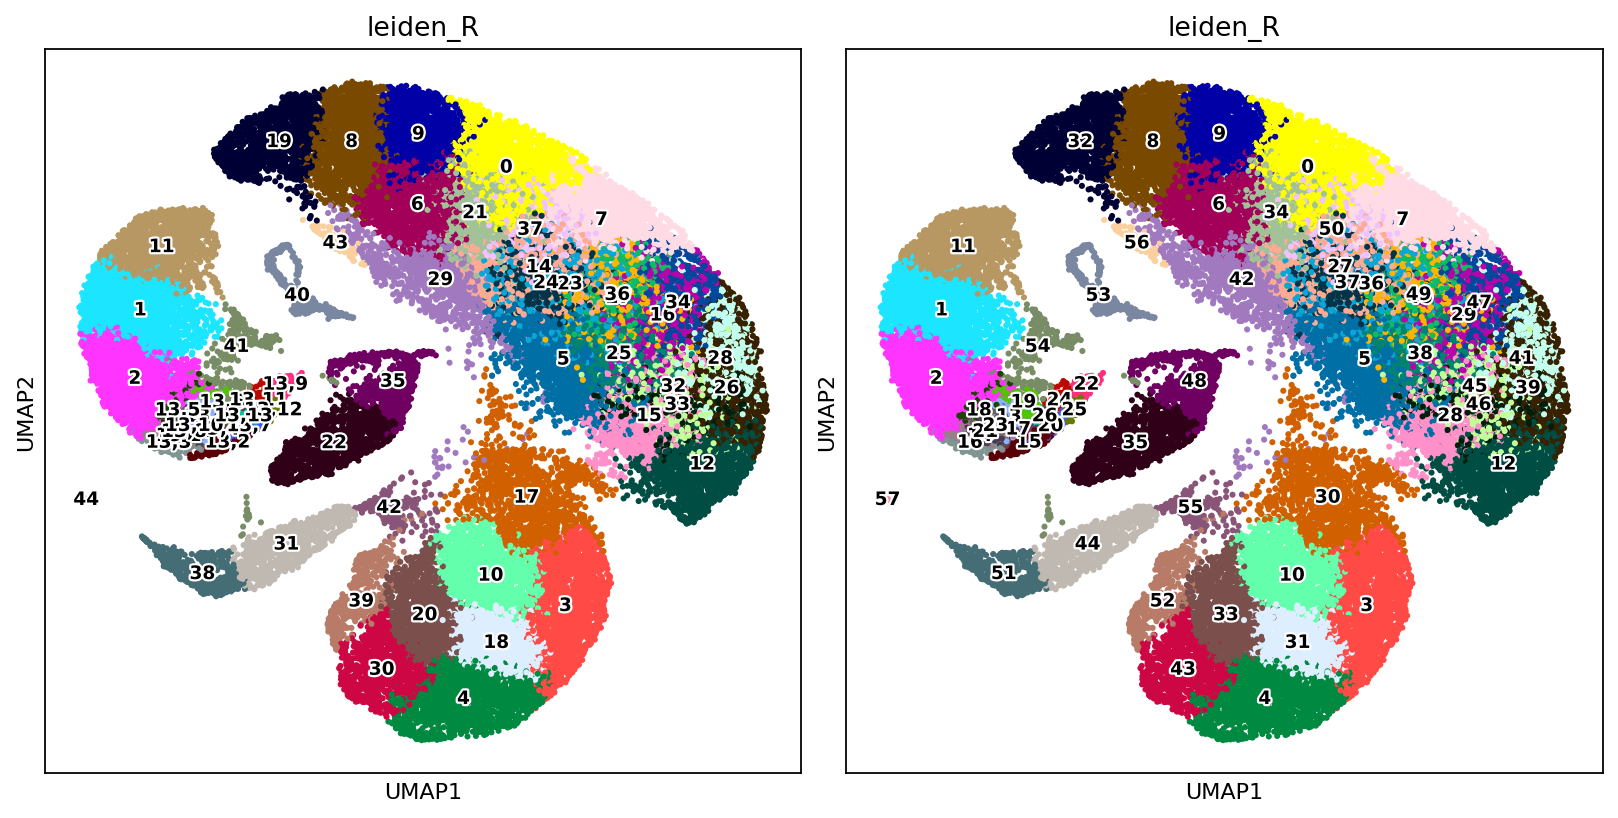

In [18]:
#### split cluster
s=30
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5),constrained_layout=True)
sc.tl.leiden(adata, resolution=0.9, restrict_to=('leiden', ['13']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data',legend_fontsize='small',legend_fontoutline=2, ax=ax1, show=False, s=s)
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data',legend_fontsize='small',legend_fontoutline=2, ax=ax2, show=False, s=s)
adata.obs['leiden'] = adata.obs['leiden_R']

In [19]:
# sc.pl.umap(adata, color=['leiden','phase','karyotype','pcw'],color_map = "OrRd", ncols=4);

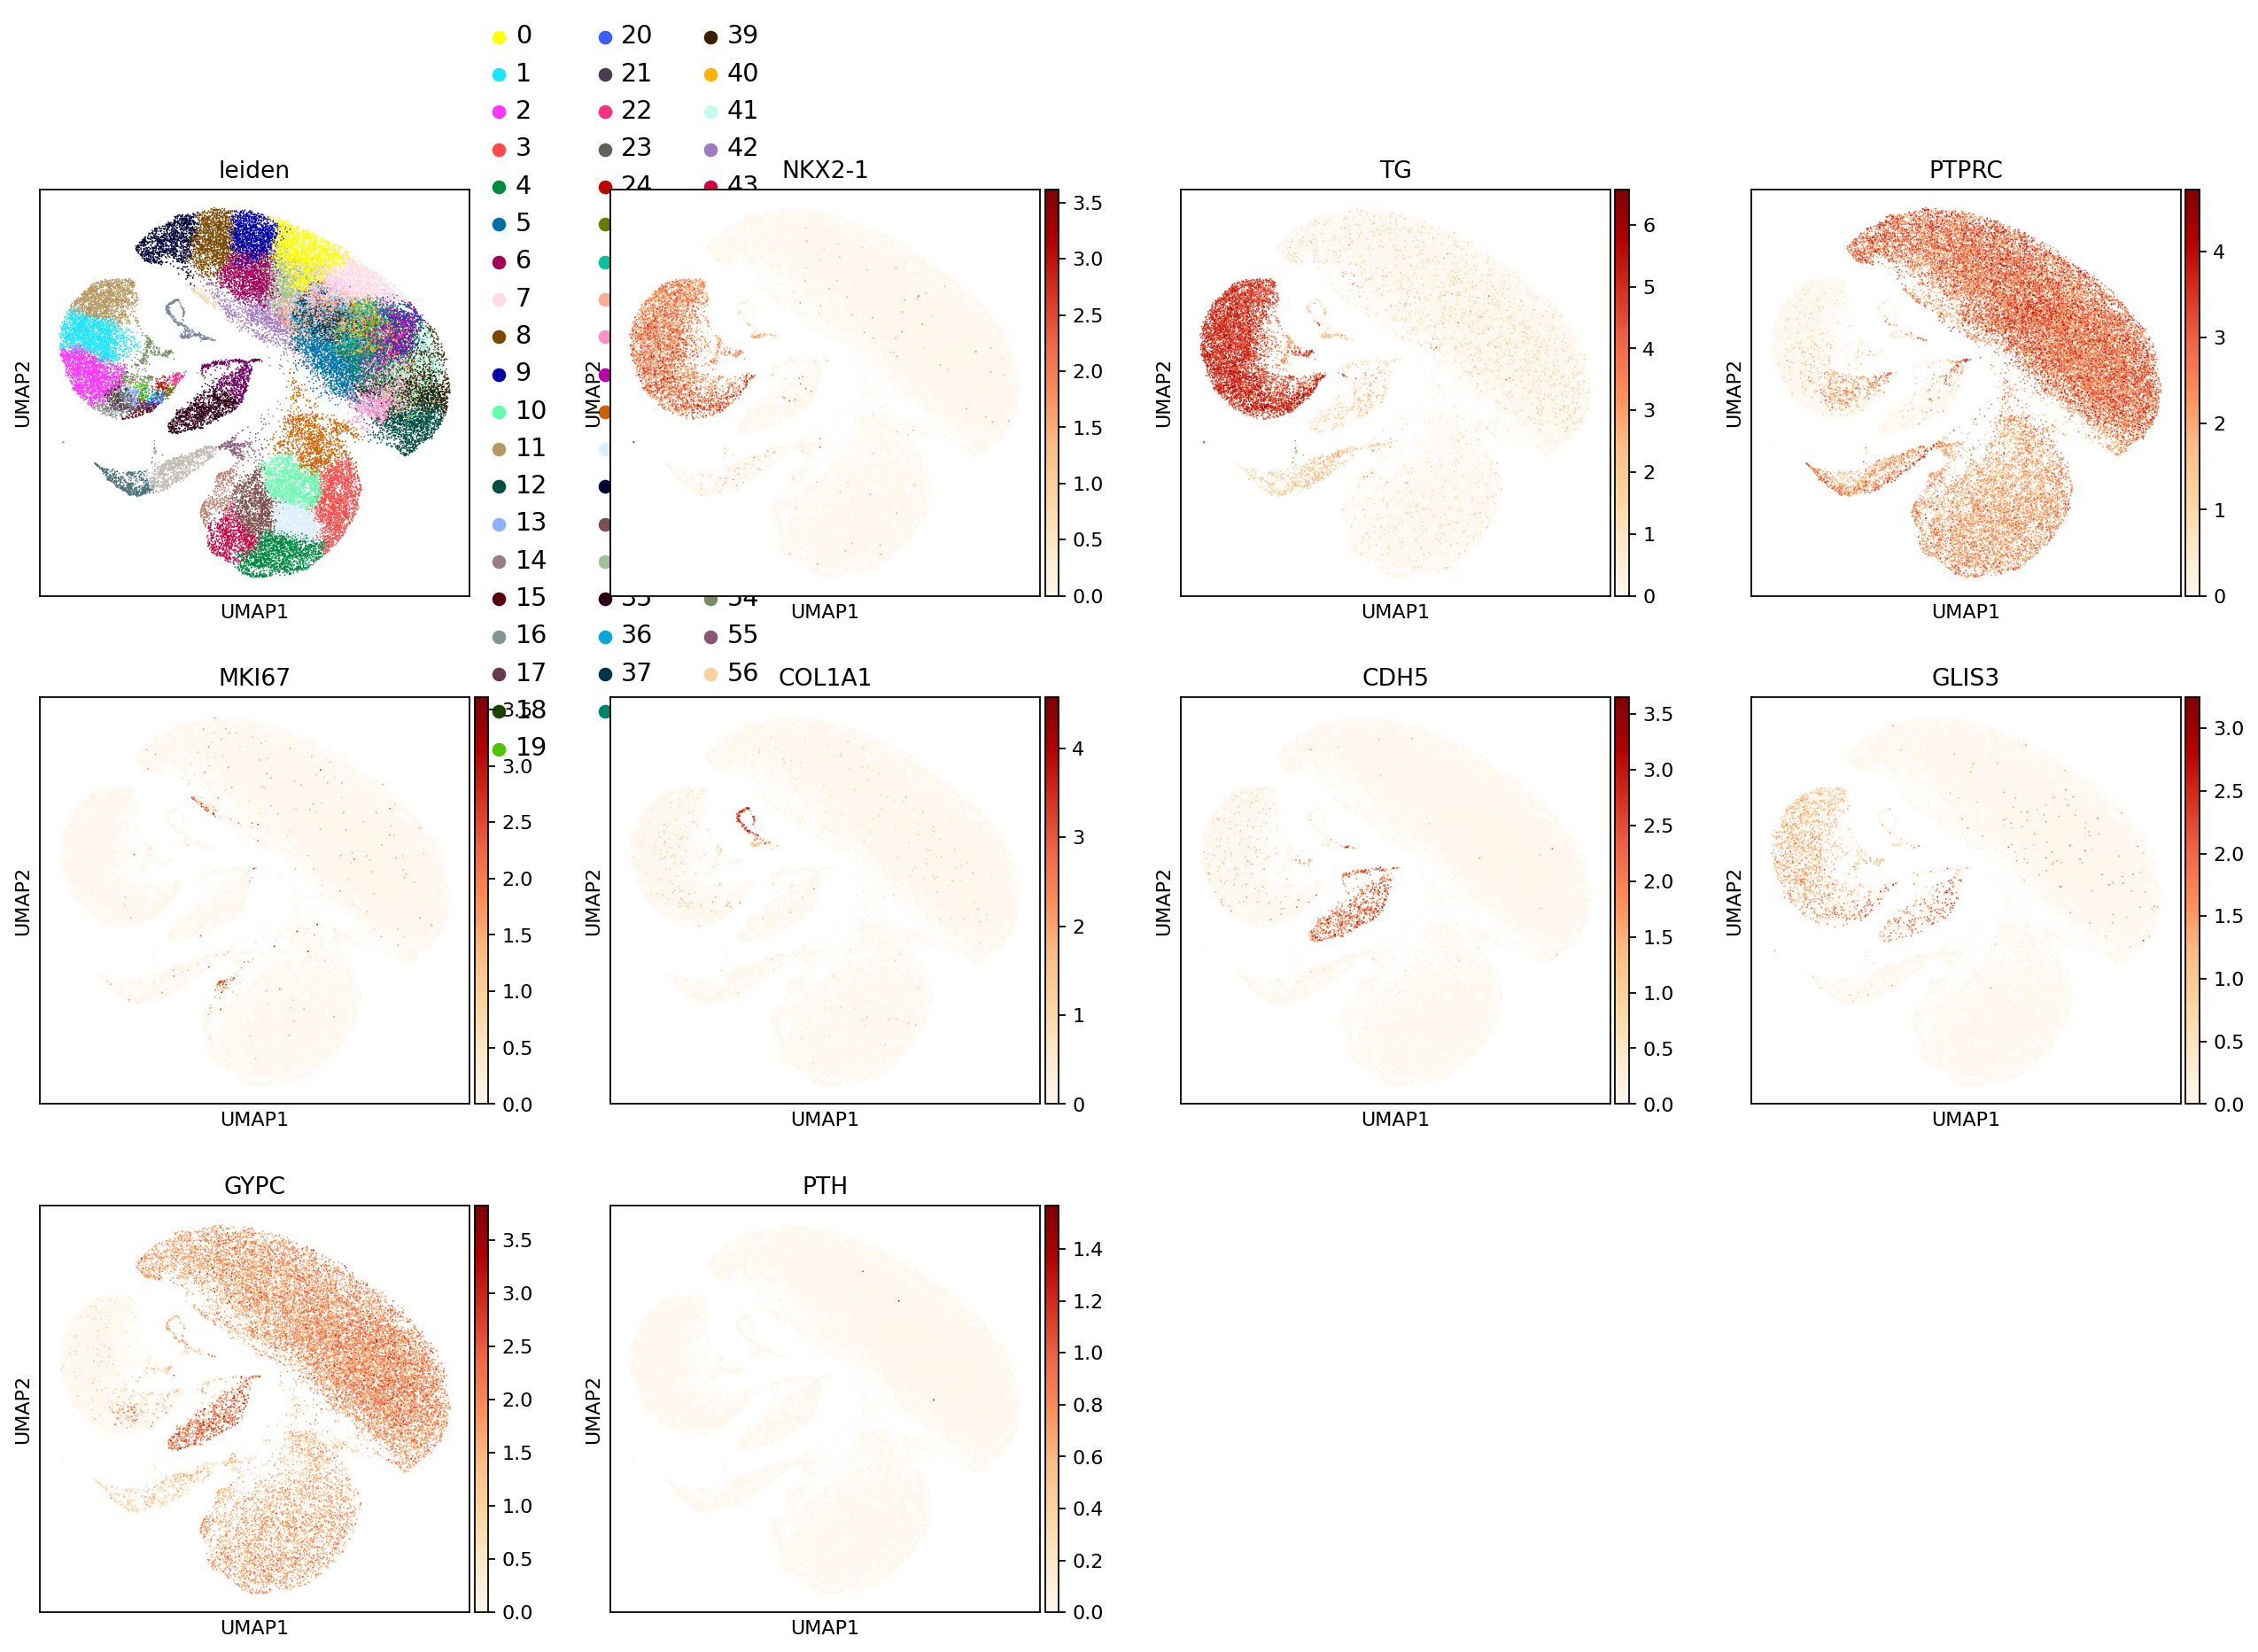

In [20]:
sc.pl.umap(adata, color=['leiden','NKX2-1','TG','PTPRC','MKI67','COL1A1','CDH5','GLIS3','GYPC','PTH'],
           color_map = "OrRd", ncols=4, use_raw=False);

In [21]:
# # original 
# mrk =  {'TFCs':['TG','TPO','TSHR','PAX8','NKX2-1','HHEX','FOXE1'],
#         'Mesenchymal cells':['COL1A1','DCN','COL3A1'],
#         'VECs':['CD34','ICAM1','PECAM1','VWF'],
#         'SMCs':['ACTA2','RGS5'],
#         'Erythroid cells':['ALAS2','HBG1','HBG2','HBB'],
#         'Schwann cells':['MPZ','SOX10','RELN','CDH19','FOXD3'],
#         'ENS': ['GAP43','SYT1','CELF4','NRG1','SNAP25','SLIT1'],
#         'LECs':['PDPN','PROX1','TFF3','FLT4','CCL21'],
#         'Parathyroid cells':['PTH','GATA3','PVALB','GCM2','CASR'],
#         'C cells' : ['CALCA','ATCAY','ACTL6B','CEACAM5'],
#         'Epithelial':['MUC1','KRT7'],
#         'Immune cells': ['PTPRC'],
#         'Mac':['CD68','CD14','LYZ'],
#         'Lymphocytes':['CD7','TRAC'],
#         'CD8+ T cells': ['CD8A', 'CD8B'],
#         'B cells':['CD19'],
#         'NK cells':['NKG7'],
#         'T cells' : ['CCR7'], 
#         'Skeletal Muscle' : ['TNNI2'],
#         'Satellite cells':['PAX7','CDH15'],
#         'Condrocytes': ['MATN4'],
#        }

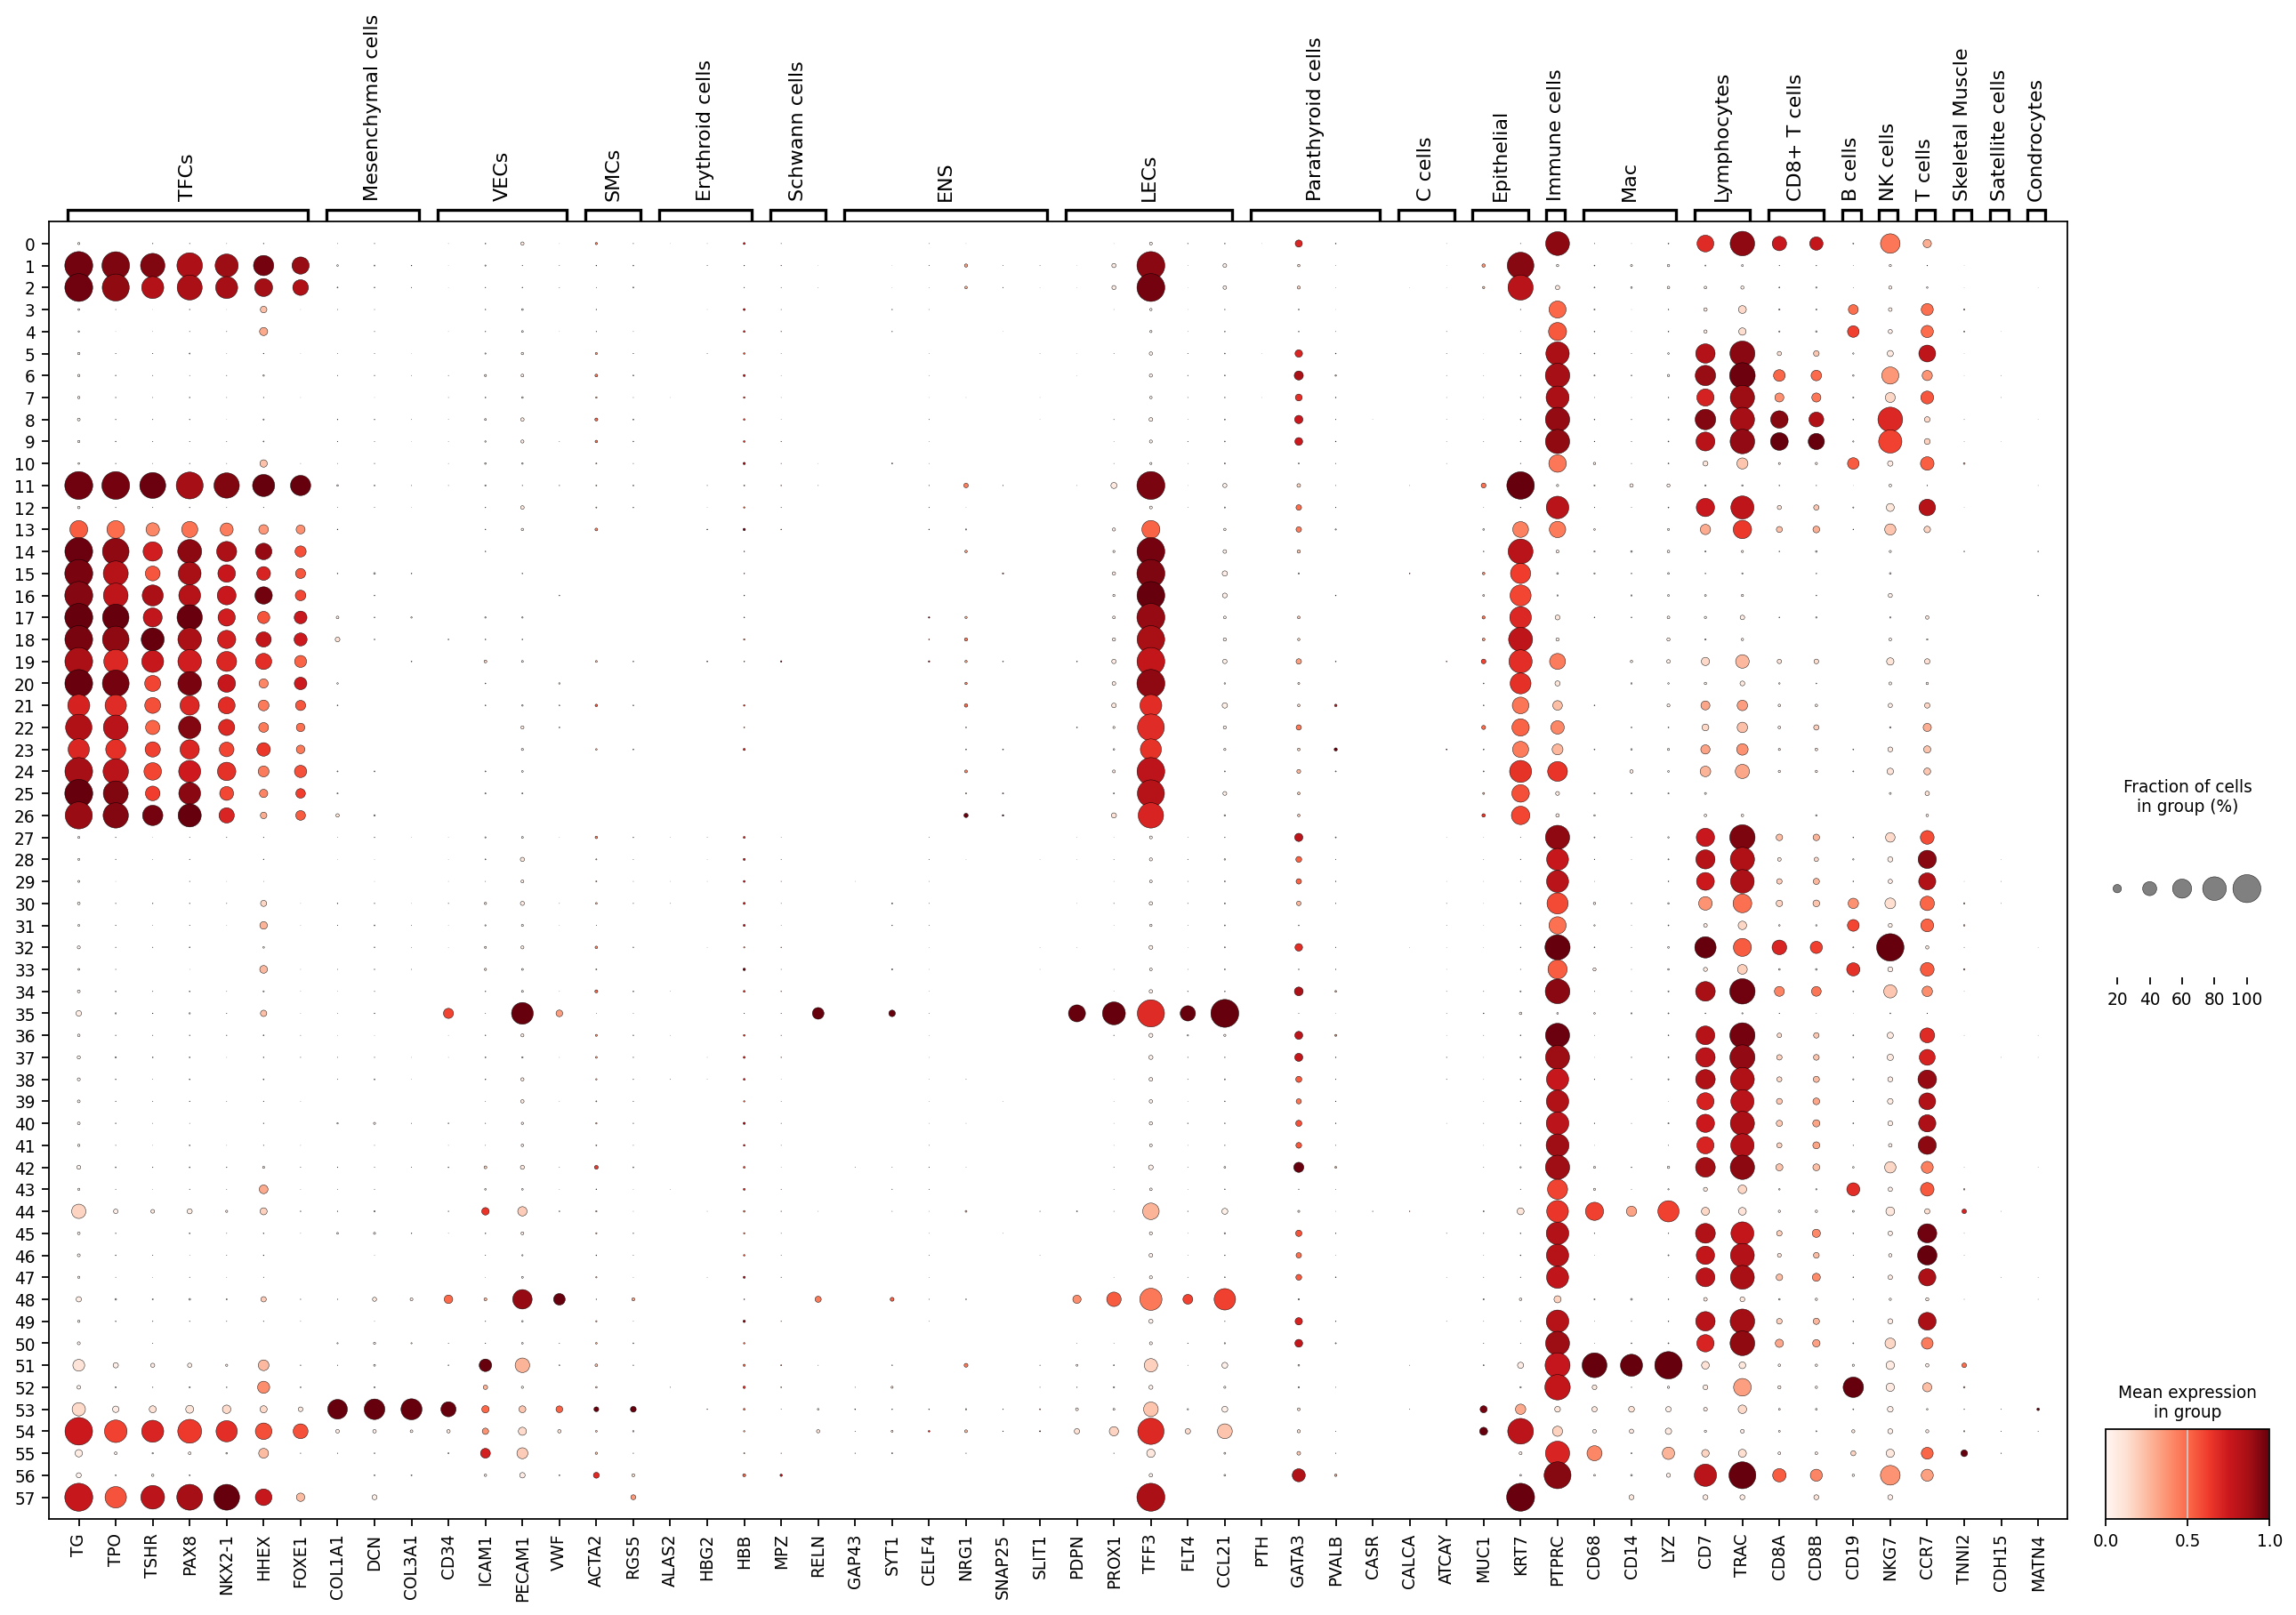

In [22]:
mrk =  {'TFCs':['TG','TPO','TSHR','PAX8','NKX2-1','HHEX','FOXE1'],
        'Mesenchymal cells':['COL1A1','DCN','COL3A1'],
        'VECs':['CD34','ICAM1','PECAM1','VWF'],
        'SMCs':['ACTA2','RGS5'],
        'Erythroid cells':['ALAS2','HBG2','HBB'],
        'Schwann cells':['MPZ','RELN'],
        'ENS': ['GAP43','SYT1','CELF4','NRG1','SNAP25','SLIT1'],
        'LECs':['PDPN','PROX1','TFF3','FLT4','CCL21'],
        'Parathyroid cells':['PTH','GATA3','PVALB','CASR'],
        'C cells' : ['CALCA','ATCAY'],
        'Epithelial':['MUC1','KRT7'],
        'Immune cells': ['PTPRC'],
        'Mac':['CD68','CD14','LYZ'],
        'Lymphocytes':['CD7','TRAC'],
        'CD8+ T cells': ['CD8A', 'CD8B'],
        'B cells':['CD19'],
        'NK cells':['NKG7'],
        'T cells' : ['CCR7'], 
        'Skeletal Muscle' : ['TNNI2'],
        'Satellite cells':['CDH15'],
        'Condrocytes': ['MATN4'],
       }
sc.pl.dotplot(adata, var_names=mrk, groupby='leiden', figsize=(20,12), dendrogram=False, standard_scale='var')

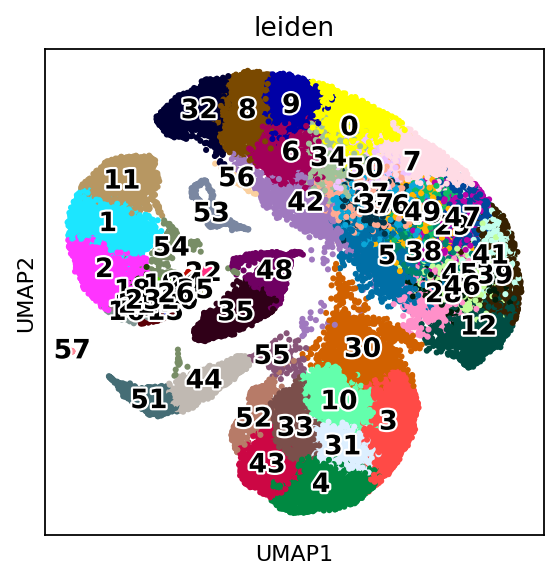

In [23]:
sc.pl.umap(adata, color=["leiden"], legend_loc='on data',legend_fontsize='large', legend_fontoutline=2,s=s)

In [24]:
# save adata normalised 
adata.write('../workingObj/Pu_2021_filter01.h5ad')

# re-analyse for Thyrocytes only 

In [25]:
clus2keep = ['1','2','11','14','15','16','17','18','20','25','26']
clus2remove = set(adata.obs['leiden'].unique().tolist()) - set(clus2keep)

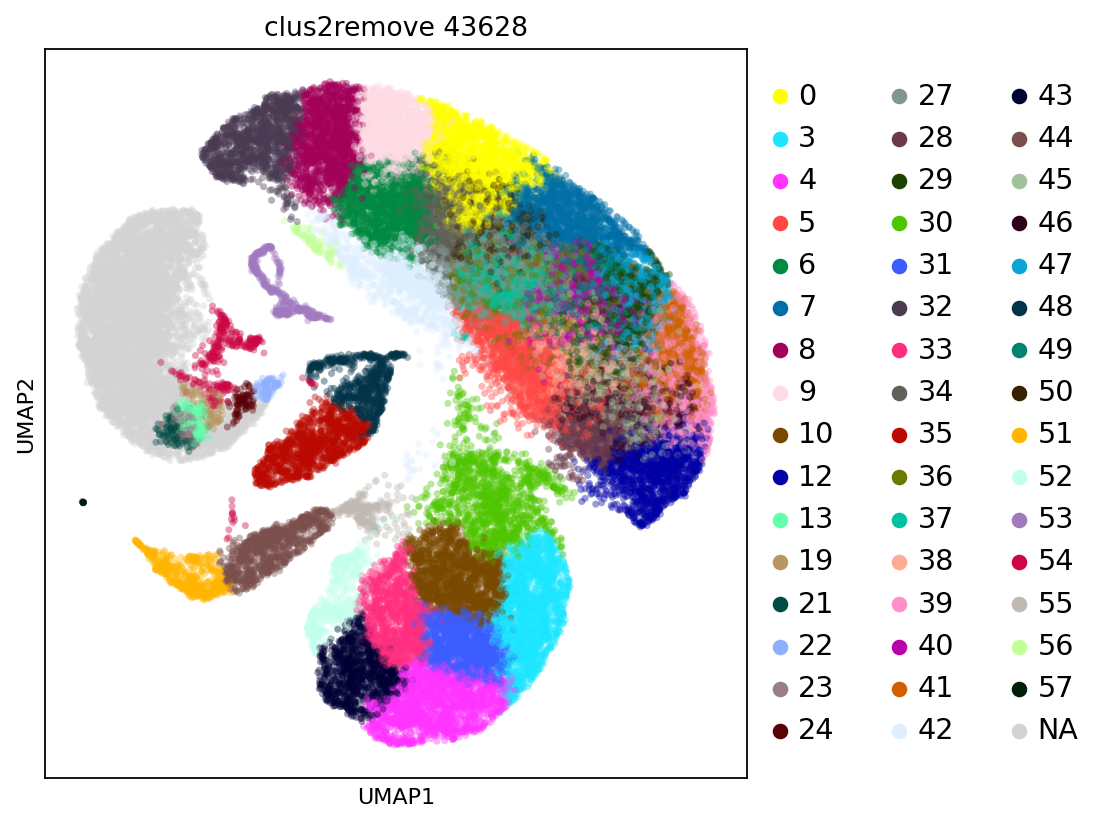

In [26]:
# # plot cluster on umap
adata.obs['clus2remove'] = adata.obs['leiden']
adata.obs.loc[adata.obs.index[adata.obs['leiden'].isin(clus2remove) == False].tolist(), 'clus2remove'] = np.nan
adata.obs['clus2remove'].cat.remove_unused_categories(inplace=True)
fig, ax = plt.subplots(1,1, figsize=(6,6),constrained_layout=False, subplot_kw=dict(aspect='equal'))
sc.pl.umap(adata, color='clus2remove',title=f'clus2remove {adata.obs["clus2remove"].value_counts().sum()}', ax=ax, s=40, alpha=0.4)

In [27]:
cell_idx2 = adata[~adata.obs['leiden'].isin(clus2remove)].obs.index
a2data = adata[cell_idx2,:]
# a2data.layers['counts'] = adata_orig[cell_idx2,:].X #copy counts
a2data.X = a2data.layers['counts']

print(f'a2data shape: {a2data.shape}')

a2data shape: (6024, 23680)


## Score cell cycle

In [28]:
a2data.X[:10,:10].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [29]:
sc.pp.normalize_per_cell(a2data, counts_per_cell_after=1e4)
sc.pp.log1p(a2data)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [30]:
# read cell cycle genes
cell_cycle_genes = [x.strip() for x in open('/nfs/team292/hm11/endo_GLND/resources/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

s_genes = [x for x in s_genes if x in a2data.var_names]
g2m_genes = [x for x in g2m_genes if x in a2data.var_names]

# score_genes_cell_cycle
sc.tl.score_genes_cell_cycle(a2data, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    795 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    839 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


## Identify HVGs

In [31]:
print(f'adata shape: {a2data.shape}')


# del(bdata)
bdata = a2data.copy()

# # subset ccga
# bdata = bdata[:,[i not in bdata.uns['ccgs'] for i in bdata.var_names]]
# print('Total number of genes after ccg filter: {:d}'.format(bdata.n_vars))

adata shape: (6024, 23680)


In [32]:
sc.pp.highly_variable_genes(bdata,
                            flavor='seurat_v3',
                            layer='counts',
                            n_top_genes=2000,
                            subset=False)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


## PCA

Total number of cells: 6024
Total number of genes: 2000
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


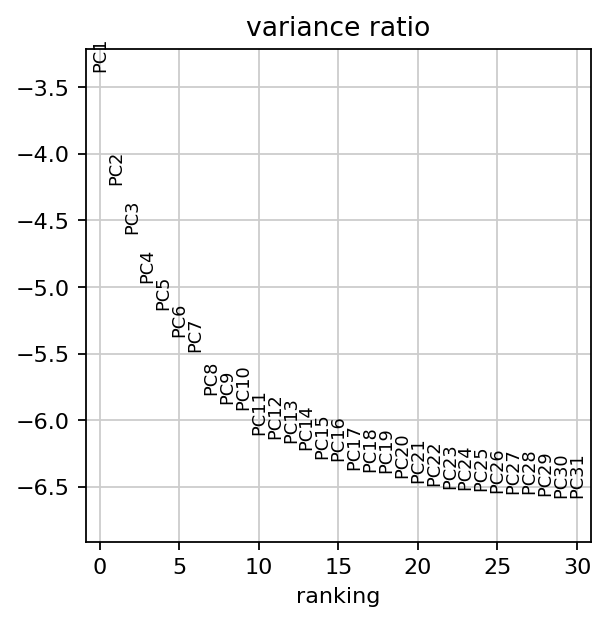

In [33]:
bdata = bdata[:, bdata.var['highly_variable']]
print('Total number of cells: {:d}'.format(bdata.n_obs))
print('Total number of genes: {:d}'.format(bdata.n_vars))

sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)
sc.pl.pca_variance_ratio(bdata, log=True)

a2data.var['highly_variable'] = bdata.var['highly_variable']
a2data.var['highly_variable'].fillna(value=False, inplace=True) # fill NaNs with False so that subsetting to HVGs is possible
# a2data.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
# a2data.uns['pca'] = bdata.uns['pca'].copy()
# a2data.varm['PCs'] = np.zeros(shape=(a2data.n_vars, 50))
# a2data.varm['PCs'][a2data.var['highly_variable']] = bdata.varm['PCs']

## Harmony

In [34]:
# code from Luz 
# Extract PCA matrix and batch array
n_pcs = 17
pca = bdata.obsm['X_pca'][:, 0:(n_pcs)]

import harmonypy as hm
ho = hm.run_harmony(pca, bdata.obs, 'batch', theta = 0)

# Add harmony values to the anndata object
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
a2data.obsm['X_pca'] = res.to_numpy().T

del(bdata)

# Visualize
sc.pp.neighbors(a2data, n_pcs = n_pcs)
sc.tl.umap(a2data)

2025-05-25 09:08:41,747 - harmonypy - INFO - Iteration 1 of 10
2025-05-25 09:08:44,661 - harmonypy - INFO - Iteration 2 of 10
2025-05-25 09:08:47,762 - harmonypy - INFO - Iteration 3 of 10
2025-05-25 09:08:50,855 - harmonypy - INFO - Iteration 4 of 10
2025-05-25 09:08:53,773 - harmonypy - INFO - Iteration 5 of 10
2025-05-25 09:08:56,575 - harmonypy - INFO - Iteration 6 of 10
2025-05-25 09:08:59,350 - harmonypy - INFO - Iteration 7 of 10
2025-05-25 09:09:02,160 - harmonypy - INFO - Iteration 8 of 10
2025-05-25 09:09:05,150 - harmonypy - INFO - Iteration 9 of 10
2025-05-25 09:09:07,861 - harmonypy - INFO - Iteration 10 of 10
2025-05-25 09:09:09,457 - harmonypy - INFO - Stopped before convergence


computing neighbors
    using 'X_pca' with n_pcs = 17
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [35]:
bk_a2data = a2data.copy()
# a2data = bk_a2data.copy()

## UMAP

In [36]:
sc.tl.leiden(a2data,resolution=0.01)

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


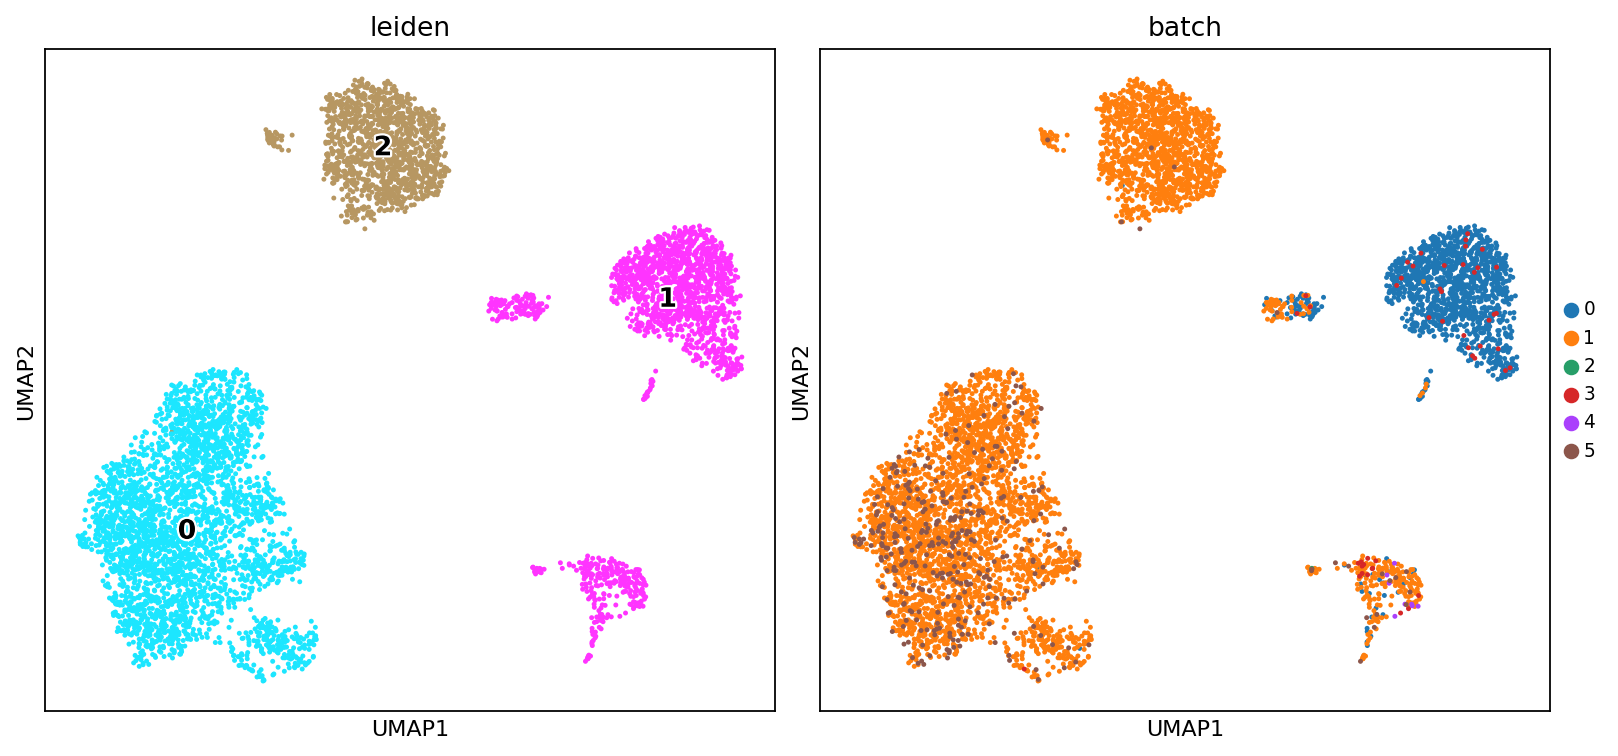

In [38]:
# use scVI imputed values for plotting
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,8),constrained_layout=True, subplot_kw=dict(aspect='equal'))
sc.pl.umap(a2data, color=["leiden"], legend_loc='on data',legend_fontsize='large', legend_fontoutline=2, ax=ax1, show=False)
sc.pl.umap(a2data, color=["batch"],legend_fontsize='small',ax=ax2, show=False)
fig.show()
# plt.savefig('figures/thy_harmony0_theta0.pdf')

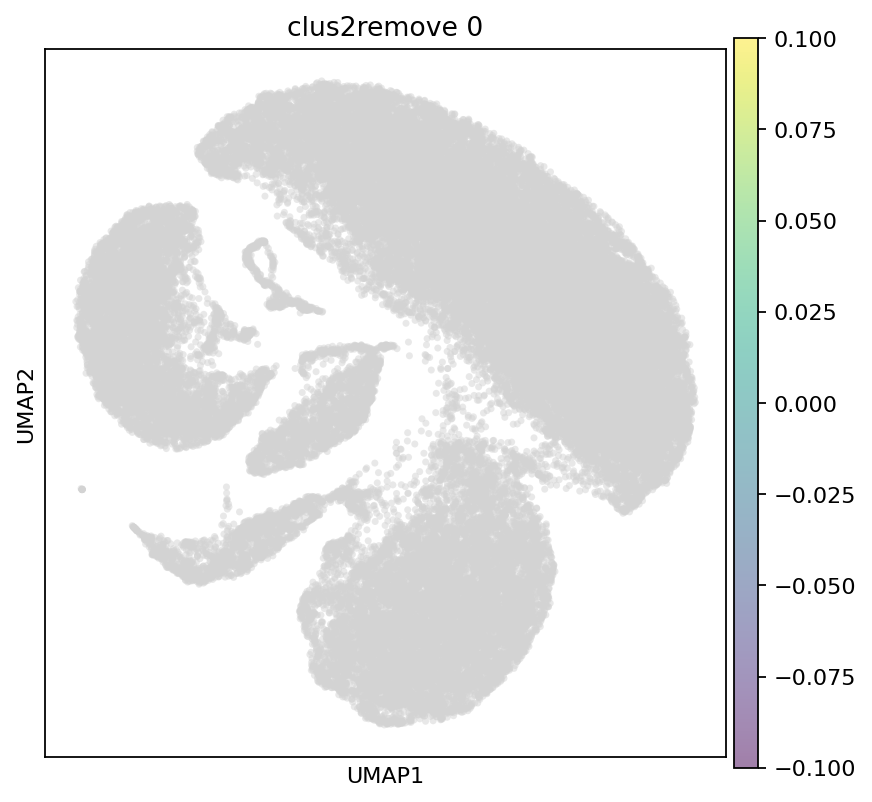

In [39]:
# show a2data clusters in adata
select = ['5']
cells = a2data.obs.loc[a2data.obs['leiden'].isin(select),'leiden']
adata.obs['clus2remove'] =  np.nan
adata.obs['clus2remove'].update(cells.astype(str))
fig, ax = plt.subplots(1,1, figsize=(6,6),constrained_layout=False, subplot_kw=dict(aspect='equal'))
sc.pl.umap(adata, color='clus2remove', title=f'clus2remove {adata.obs["clus2remove"].value_counts().sum()}', s=40, alpha=0.5, ax=ax)

In [40]:
# ### split cluster
# s=30

# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5),constrained_layout=True)
# sc.tl.leiden(a2data, resolution=0.09, restrict_to=('leiden', ['2']))
# sc.pl.umap(a2data, color='leiden_R',legend_loc='on data',legend_fontsize='small',legend_fontoutline=2, ax=ax1, show=False, s=s)
# a2data.obs['leiden_R'].cat.categories = [str(i) for i in range(len(a2data.obs['leiden_R'].cat.categories))]
# sc.pl.umap(a2data, color='leiden_R',legend_loc='on data',legend_fontsize='small',legend_fontoutline=2, ax=ax2, show=False, s=s)
# a2data.obs['leiden'] = a2data.obs['leiden_R']

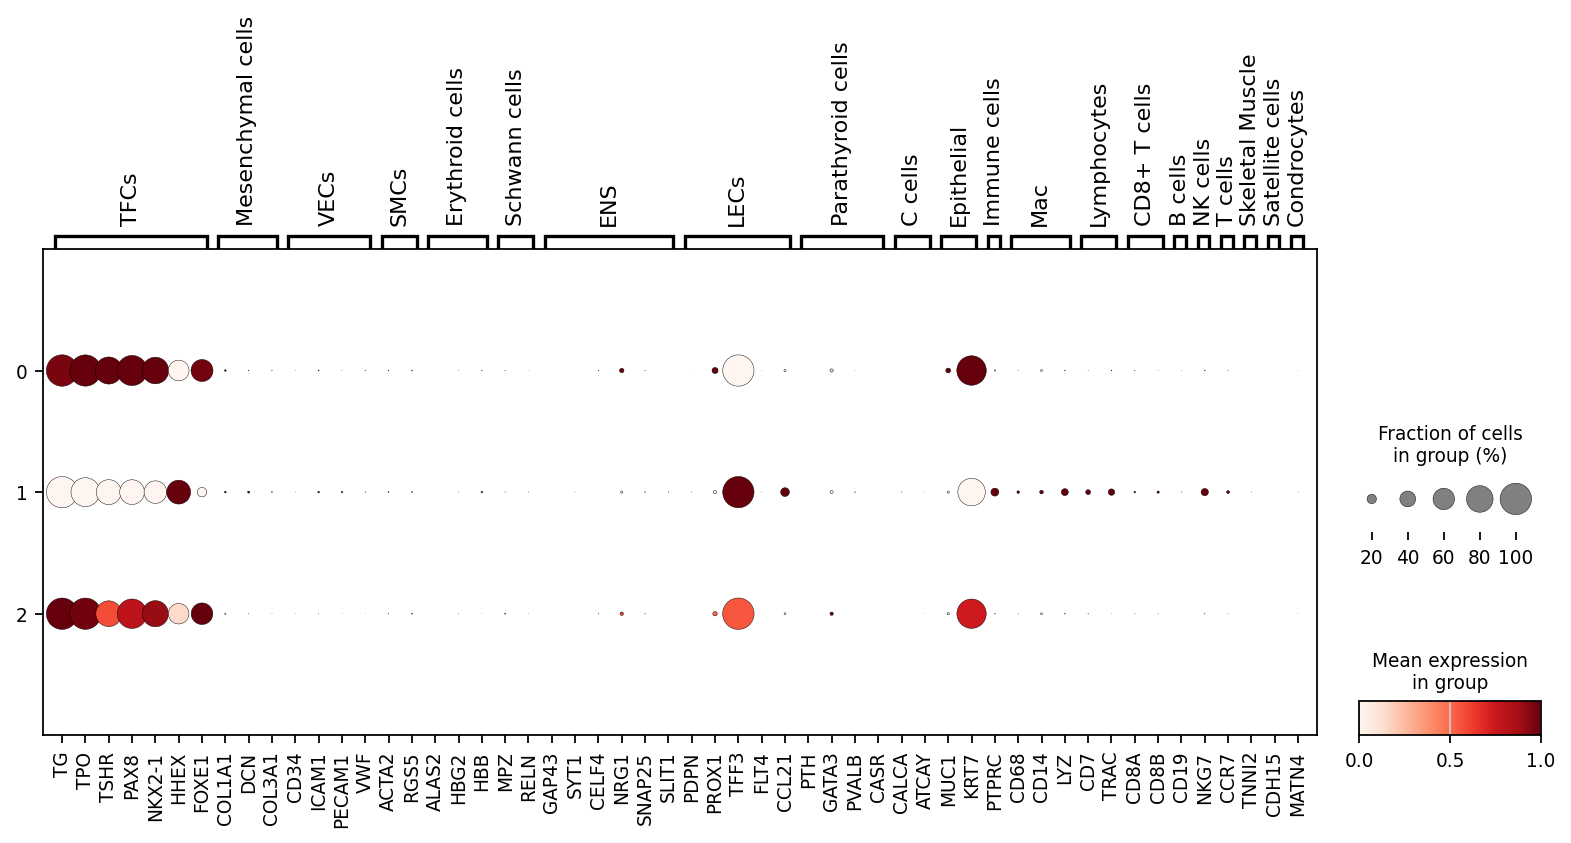

In [41]:

sc.pl.dotplot(a2data, var_names=mrk, groupby='leiden', figsize=(12,4), dendrogram=False, standard_scale='var')

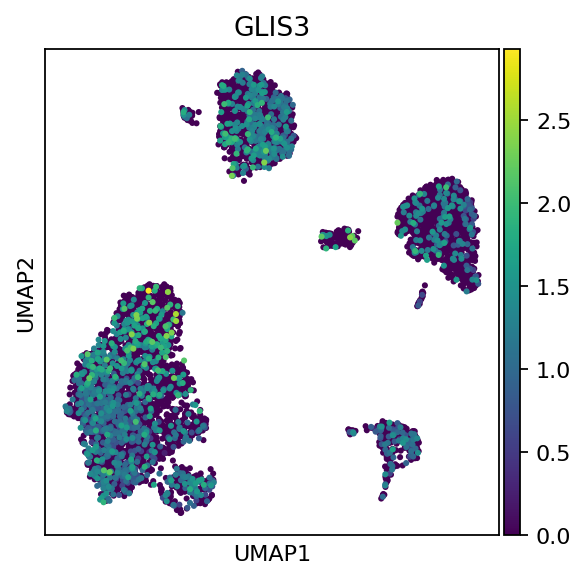

In [42]:
sc.pl.umap(a2data, color=['GLIS3'],s=30)

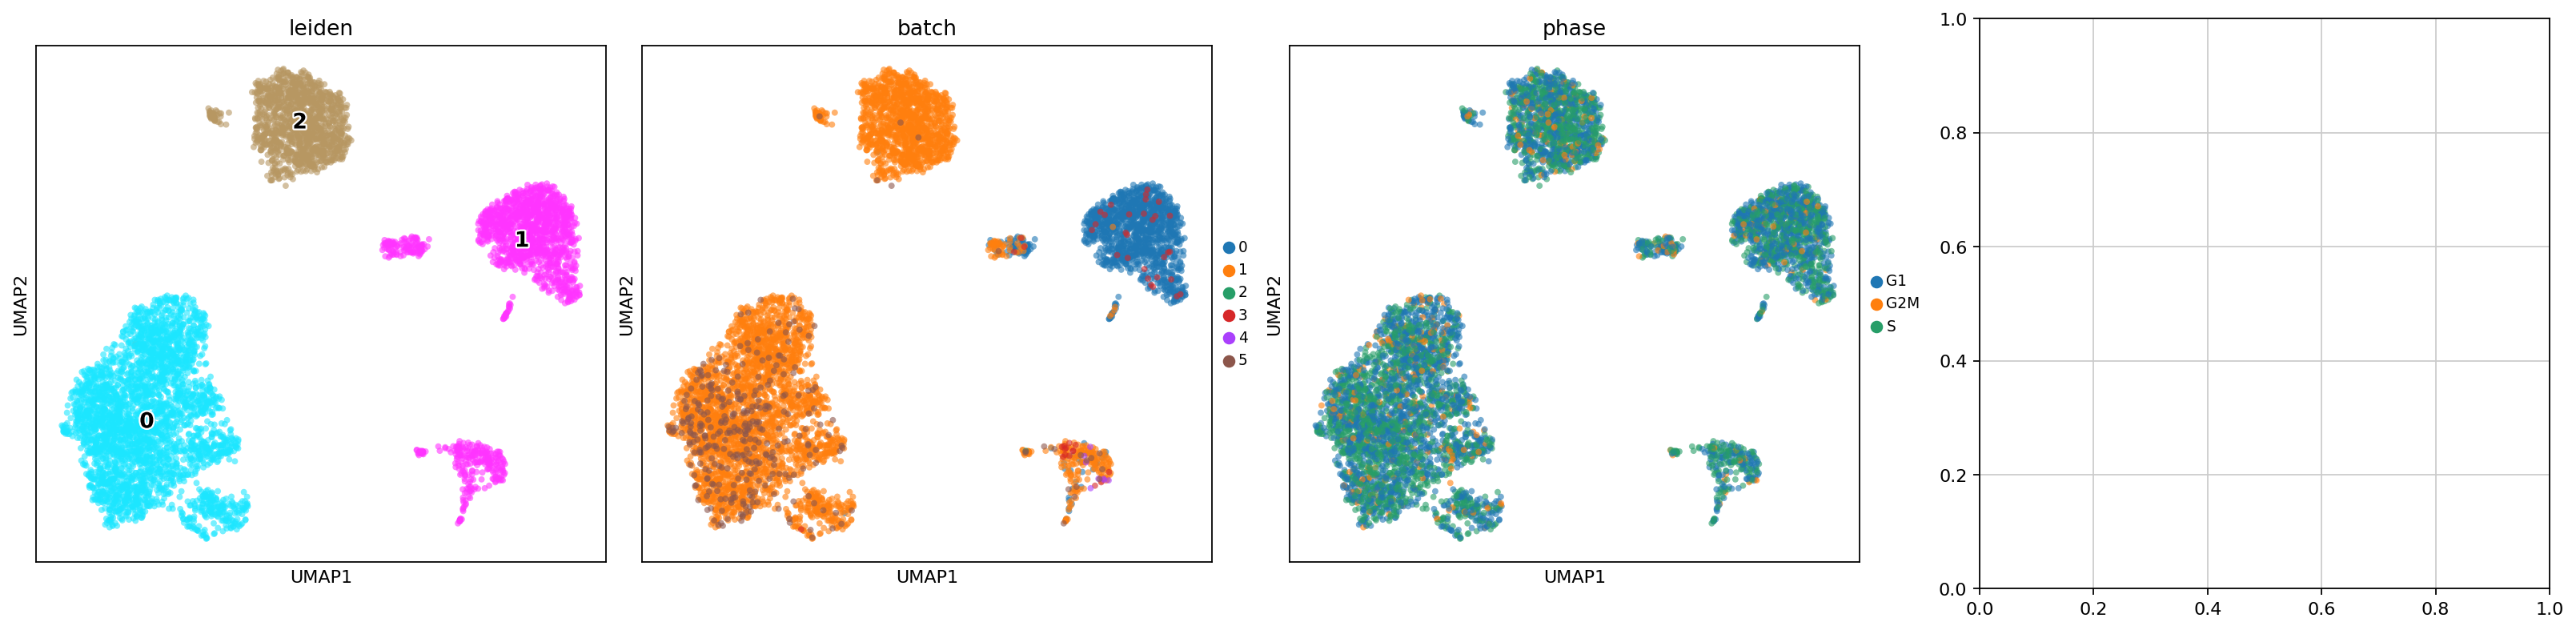

In [43]:
fig, ax = plt.subplots(1,4, figsize=(20,20),constrained_layout=True, subplot_kw=dict(aspect='equal'))
s=50
alpha=0.6
sc.pl.umap(a2data, color=["leiden"], legend_loc='on data',legend_fontsize='large', legend_fontoutline=2, s=s, alpha=alpha, show=False, ax=ax[0])
sc.pl.umap(a2data, color=["batch"],legend_fontsize='small',s=s, alpha=alpha, show=False, ax=ax[1])
sc.pl.umap(a2data, color=["phase"],legend_fontsize='small',s=s, alpha=alpha, show=False, ax=ax[2])
# sc.pl.umap(a2data, color=["pcw"],legend_fontsize='small',s=s, alpha=alpha, show=False, ax=ax[3])
fig.show()

<Axes: title={'center': 'batch %'}, ylabel='leiden'>

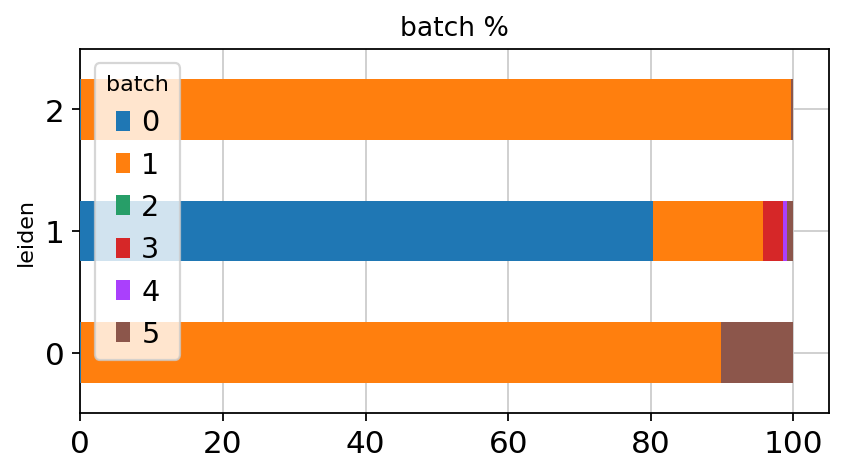

In [44]:
# donor contribution
height = 2
sf.Barplot('batch', a2data, var='leiden', height=height)

In [45]:
a2data.obs.columns

Index(['sample', 'donor_id', 'batch', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes',
       'n_counts', 'leiden', 'leiden_R', 'clus2remove', 'S_score', 'G2M_score',
       'phase'],
      dtype='object')

## save

In [46]:
a2data.write('../workingObj/Pu_2021_cThy.h5ad')